In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
import warnings
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
warnings.filterwarnings("ignore")

In [23]:
def get_data(filename,test_size=0.25):
    '''
    Read data from file
    Input:
        filename: name of the csv file to read data from
        test_size: proportion of data to be used for testing
    Output: pd.Dataframe
        train,test: treain and test dataframes
    '''
    data_ = pd.read_csv(filename)
    train = data_.sample(frac=0.75, random_state=0)
    test = data_.drop(train.index)
    return train,test
train,test = get_data("./adult_processed.csv")

In [24]:
def fit_models(data):
    '''
    Fit models for each covariate using the causal parents from the DAG
    Input: pd.Dataframe
        data: A pandas dataframe to train the model on
    Output:
        model_Y: A model for the output (Y)
        A dictionary containing the coefficients for all the covariates
    '''
    #Train a model for M
    # M ~ A+C
    model_M = LinearRegression(fit_intercept=True)
    model_M.fit(data[['male','race','age','native_country']],data[['married']])
    beta_M = np.concatenate((model_M.intercept_,model_M.coef_[0]),axis=0)

    #Train a model for L
    #L ~ A+C+M
    model_L = LinearRegression()
    model_L.fit(data[['male','race','age','native_country','married']],data[['higher_edu']])
    beta_L = np.concatenate((model_L.intercept_,model_L.coef_[0]),axis=0)

    #Train a model for R_1
    #R_1 ~ A+C+M+L
    model_R_1 = LinearRegression(fit_intercept=True)
    model_R_1.fit(data[['male','race','age','native_country','married','higher_edu']],data[['managerial_occ']])
    beta_R_1 = np.concatenate((model_R_1.intercept_,model_R_1.coef_[0]),axis=0)

    #Train a model for R_2
    #R_2 ~ A+C+M+L
    model_R_2 = LinearRegression(fit_intercept=True)
    model_R_2.fit(data[['male','race','age','native_country','married','higher_edu']],data[['high_hours']])
    beta_R_2 = np.concatenate((model_R_2.intercept_,model_R_2.coef_[0]),axis=0)

    #Train a model for R_3
    #R_3 ~ A+C+M+L
    model_R_3 = LinearRegression(fit_intercept=True)
    model_R_3.fit(data[['male','race','age','native_country','married','higher_edu']],data[['gov_jobs']])
    beta_R_3 = np.concatenate((model_R_3.intercept_,model_R_3.coef_[0]),axis=0)

    #Train a model for Y
    #Y ~ P + I + AI
    model_Y = LogisticRegression(penalty='l2',solver='saga', fit_intercept=True)
    model_Y = model_Y.fit(data[['male','race','age','native_country','married','higher_edu','managerial_occ','high_hours','gov_jobs']],data[['high_income']])
    beta_Y = np.concatenate((model_Y.intercept_,model_Y.coef_[0]),axis=0)
    return model_Y,{'M':beta_M, 'L':beta_L, 'R_1':beta_R_1, 'R_2':beta_R_2, 'R_3':beta_R_3, 'Y':beta_Y}


def classifiers_all(train):
    '''
    Train classifiers for all the covariates
    Input: pd.Dataframe
        dataframe for training dataset
    Output:
        model for Y
        A dictionary with coefficients of models for each covariate
    '''
    model_Y, beta_lm = fit_models(train)

    return model_Y,beta_lm
model_Y,beta_lm = classifiers_all(train)


In [25]:
def test_model(model,data_test):
    '''
    Obtain predictions
    Input: model to use for obtaining predictions, dataframe of test dataset
    Output: predictions
    '''
    preds = model.predict_proba(data_test[['male','race','age','native_country','married','higher_edu','managerial_occ','high_hours','gov_jobs']])
    return preds

In [26]:
def random_logit(x):
    z = 1./(1+np.exp(-x))
    s = np.random.binomial(n=1, p=z)
    return s

def gen_counterfactual(data,beta):
    '''
    Generate counterfactual data using coefficients from models for each covariate
    '''
    original = data.copy()
    original['married'] = beta['M'][0] + beta['M'][1]*original['male'] + beta['M'][2]*original['race'] + beta['M'][3]*original['age'] + beta['M'][4]*original['native_country']

    original['higher_edu'] = beta['L'][0] + beta['L'][1]*original['male'] + beta['L'][2]*original['race'] + beta['L'][3]*original['age'] + beta['L'][4]*original['native_country'] + beta['L'][5]*original['married']

    original['managerial_occ'] = beta['R_1'][0] + beta['R_1'][1]*original['male'] + beta['R_1'][2]*original['race'] + beta['R_1'][3]*original['age'] + beta['R_1'][4]*original['native_country'] + beta['R_1'][5]*original['married'] + beta['R_1'][6]*original['higher_edu']

    original['high_hours'] = beta['R_2'][0] + beta['R_2'][1]*original['male'] + beta['R_2'][2]*original['race'] + beta['R_2'][3]*original['age'] + beta['R_2'][4]*original['native_country'] + beta['R_2'][5]*original['married'] + beta['R_2'][6]*original['higher_edu']

    original['gov_jobs'] = beta['R_3'][0] + beta['R_3'][1]*original['male'] + beta['R_3'][2]*original['race'] + beta['R_3'][3]*original['age'] + beta['R_3'][4]*original['native_country'] + beta['R_3'][5]*original['married'] + beta['R_3'][6]*original['higher_edu']

    original['high_income'] = random_logit(beta['Y'][0] + beta['Y'][1]*original['male'] + beta['Y'][2]*original['race'] + beta['Y'][3]*original['age'] + beta['Y'][4]*original['native_country'] + beta['Y'][5]*original['married'] + beta['Y'][6]*original['higher_edu'] + beta['Y'][7]*original['managerial_occ'] + beta['Y'][8]*original['high_hours'] + beta['Y'][9]*original['gov_jobs'])

    counterfactual_data = data.copy()
    counterfactual_data['married'] = counterfactual_data['married'].apply(lambda x: 6 if x==1 else x)

    counterfactual_data['male'] = counterfactual_data['male'].apply(lambda x: 0 if x==1 else 1)

    counterfactual_data['higher_edu'] = beta['L'][0] + beta['L'][1]*counterfactual_data['male'] + beta['L'][2]*counterfactual_data['race'] + beta['L'][3]*counterfactual_data['age'] + beta['L'][4]*counterfactual_data['native_country'] + beta['L'][5]*counterfactual_data['married']

    counterfactual_data['managerial_occ'] = beta['R_1'][0] + beta['R_1'][1]*counterfactual_data['male'] + beta['R_1'][2]*counterfactual_data['race'] + beta['R_1'][3]*counterfactual_data['age'] + beta['R_1'][4]*counterfactual_data['native_country'] + beta['R_1'][5]*counterfactual_data['married'] + beta['R_1'][6]*counterfactual_data['higher_edu']

    counterfactual_data['high_hours'] = beta['R_2'][0] + beta['R_2'][1]*counterfactual_data['male'] + beta['R_2'][2]*counterfactual_data['race'] + beta['R_2'][3]*counterfactual_data['age'] + beta['R_2'][4]*counterfactual_data['native_country'] + beta['R_2'][5]*counterfactual_data['married'] + beta['R_2'][6]*counterfactual_data['higher_edu']

    counterfactual_data['gov_jobs'] = beta['R_3'][0] + beta['R_3'][1]*counterfactual_data['male'] + beta['R_3'][2]*counterfactual_data['race'] + beta['R_3'][3]*counterfactual_data['age'] + beta['R_3'][4]*counterfactual_data['native_country'] + beta['R_3'][5]*counterfactual_data['married'] + beta['R_3'][6]*counterfactual_data['higher_edu']

    counterfactual_data['high_income'] = random_logit(beta['Y'][0] + beta['Y'][1]*counterfactual_data['male'] + beta['Y'][2]*counterfactual_data['race'] + beta['Y'][3]*counterfactual_data['age'] + beta['Y'][4]*counterfactual_data['native_country'] + beta['Y'][5]*counterfactual_data['married'] + beta['Y'][6]*counterfactual_data['higher_edu'] + beta['Y'][7]*counterfactual_data['managerial_occ'] + beta['Y'][8]*counterfactual_data['high_hours'] + beta['Y'][9]*counterfactual_data['gov_jobs'])

    counterfactual_pop = data.copy()
    temp = list(counterfactual_pop['native_country'])
    for i in temp:
        if i != 39:
            i = 39
    counterfactual_pop['native_country'] = temp
    counterfactual_pop['managerial_occ'] = beta['R_1'][0] + beta['R_1'][1]*counterfactual_pop['male'] + beta['R_1'][2]*counterfactual_pop['race'] + beta['R_1'][3]*counterfactual_pop['age'] + beta['R_1'][4]*counterfactual_pop['native_country'] + beta['R_1'][5]*counterfactual_pop['married'] + beta['R_1'][6]*counterfactual_pop['higher_edu']

    counterfactual_pop['high_hours'] = beta['R_2'][0] + beta['R_2'][1]*counterfactual_pop['male'] + beta['R_2'][2]*counterfactual_pop['race'] + beta['R_2'][3]*counterfactual_pop['age'] + beta['R_2'][4]*counterfactual_pop['native_country'] + beta['R_2'][5]*counterfactual_pop['married'] + beta['R_2'][6]*counterfactual_pop['higher_edu']

    counterfactual_pop['gov_jobs'] = beta['R_3'][0] + beta['R_3'][1]*counterfactual_pop['male'] + beta['R_3'][2]*counterfactual_pop['race'] + beta['R_3'][3]*counterfactual_pop['age'] + beta['R_3'][4]*counterfactual_pop['native_country'] + beta['R_3'][5]*counterfactual_pop['married'] + beta['R_3'][6]*counterfactual_pop['higher_edu']

    counterfactual_pop['high_income'] = random_logit(beta['Y'][0] + beta['Y'][1]*counterfactual_pop['male'] + beta['Y'][2]*counterfactual_pop['race'] + beta['Y'][3]*counterfactual_pop['age'] + beta['Y'][4]*counterfactual_pop['native_country'] + beta['Y'][5]*counterfactual_pop['married'] + beta['Y'][6]*counterfactual_pop['higher_edu'] + beta['Y'][7]*counterfactual_pop['managerial_occ'] + beta['Y'][8]*counterfactual_pop['high_hours'] + beta['Y'][9]*counterfactual_pop['gov_jobs'])

    counterfactual_pop_indi = data.copy()
    temp = list(counterfactual_pop_indi['native_country'])
    for i in temp:
        if i !=39 :
            i=39

    counterfactual_pop_indi['native_country'] = temp
    counterfactual_pop_indi['male'] = counterfactual_pop_indi['male'].apply(lambda x: 0 if x==1 else 1)
    counterfactual_pop['married'] = counterfactual_pop['married'].apply(lambda x: 6 if x==1 else x)

    counterfactual_pop_indi['managerial_occ'] = beta['R_1'][0] + beta['R_1'][1]*counterfactual_pop_indi['male'] + beta['R_1'][2]*counterfactual_pop_indi['race'] + beta['R_1'][3]*counterfactual_pop_indi['age'] + beta['R_1'][4]*counterfactual_pop_indi['native_country'] + beta['R_1'][5]*counterfactual_pop_indi['married'] + beta['R_1'][6]*counterfactual_pop_indi['higher_edu']

    counterfactual_pop_indi['high_hours'] = beta['R_2'][0] + beta['R_2'][1]*counterfactual_pop_indi['male'] + beta['R_2'][2]*counterfactual_pop_indi['race'] + beta['R_2'][3]*counterfactual_pop_indi['age'] + beta['R_2'][4]*counterfactual_pop_indi['native_country'] + beta['R_2'][5]*counterfactual_pop_indi['married'] + beta['R_2'][6]*counterfactual_pop_indi['higher_edu']

    counterfactual_pop_indi['gov_jobs'] = beta['R_3'][0] + beta['R_3'][1]*counterfactual_pop_indi['male'] + beta['R_3'][2]*counterfactual_pop_indi['race'] + beta['R_3'][3]*counterfactual_pop_indi['age'] + beta['R_3'][4]*counterfactual_pop_indi['native_country'] + beta['R_3'][5]*counterfactual_pop_indi['married'] + beta['R_3'][6]*counterfactual_pop_indi['higher_edu']

    counterfactual_pop_indi['high_income'] = random_logit(beta['Y'][0] + beta['Y'][1]*counterfactual_pop_indi['male'] + beta['Y'][2]*counterfactual_pop_indi['race'] + beta['Y'][3]*counterfactual_pop_indi['age'] + beta['Y'][4]*counterfactual_pop_indi['native_country'] + beta['Y'][5]*counterfactual_pop_indi['married'] + beta['Y'][6]*counterfactual_pop_indi['higher_edu'] + beta['Y'][7]*counterfactual_pop_indi['managerial_occ'] + beta['Y'][8]*counterfactual_pop_indi['high_hours'] + beta['Y'][9]*counterfactual_pop_indi['gov_jobs'])

    return original,counterfactual_data,counterfactual_pop,counterfactual_pop_indi
    

In [27]:
original,counterfactual_data,counterfactual_pop,counterfactual_pop_indi = gen_counterfactual(train,beta_lm)

In [28]:
model_original,beta_original = classifiers_all(original)
preds_original = test_model(model_original,test)


In [29]:
model_counterfactual,beta_counterfactual = classifiers_all(counterfactual_data)
preds_counterfactual = test_model(model_counterfactual,test)


In [30]:
model_counterfactual_pop,beta_counterfactual_pop = classifiers_all(counterfactual_pop)
preds_counterfactual_pop = test_model(model_counterfactual_pop,test)


In [31]:
model_counterfactual_pop_indi,beta_counterfactual_pop_indi = classifiers_all(counterfactual_pop_indi)
preds_counterfactual_pop_indi = test_model(model_counterfactual_pop_indi,test)


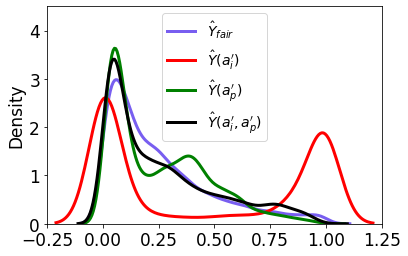

In [32]:
plt.figure()
colors = ('#1A85FF', '#FE6100', '#FFB000', '#785EF0', '#D41159')

sns.distplot(preds_original[:,1],hist=False , color="#785EF0",kde_kws={'alpha':1,'linewidth':3}, label=r"$\hat{Y}_{fair}$")
sns.distplot(preds_counterfactual_pop[:,1],hist=False, color="red",kde_kws={'alpha':1,'linewidth':3} ,label=r"$\hat{Y}(a_i')$")
sns.distplot(preds_counterfactual[:,1] ,hist=False, color="green", kde_kws={'alpha':1,'linewidth':3},label=r"$\hat{Y}(a_p')$")
sns.distplot(preds_counterfactual_pop_indi[:,1],hist=False, color="black",kde_kws={'alpha':1,'linewidth':3}, label=r"$\hat{Y}(a_i',a_p')$")

plt.rcParams['font.size'] = 17
plt.rcParams['legend.fontsize'] = 14
plt.axis([-0.25, 1.25, 0, 4.5])
plt.ylabel("Density")
plt.legend(loc='best')
plt.show()